## <span style="color:green"> Notebook - Melt Estimation</span>
<span style="color:purple">Sinan Ozaydin, School of Geosciences, The University of Sydney, NSW 2006, Australia <br/> </span>
<span style="color:purple">sinan.ozaydin@protonmail.com | sinan.ozaydin@sydney.edu.au </span>

In this notebook, we will use experimental electrical conductivity measurements.

In [1]:
#Importing the neccesarry python libraries.
import os
import pide
from pide.inversion import conductivity_solver_single_param, conductivity_metropolis_hastings_two_param
from pide.imaging.plot_distribution import plot_posterior_distribution_two_params, plot_posterior_distribution_heatmap_two_params
import numpy as np
import matplotlib.pyplot as plt

/home/sinan/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
p_obj = pide.pide()
melt_econd = p_obj.list_melt_econd_models()

Conductivity models for melts:
0.   Sifre2014_Wet_Carbonated
1.   Pommier2008_WetBasalt_Na
2.   Ni2011_WetBasalt
3.   Scarlato2004_DryBasalt_H1604
4.   TyburczyWaff1983_DryTholeiite
5.   TyburczyWaff1983_DryAndesite
6.   Guo2017_WetAndesite
7.   Laumonier2017_WetAndesite
8.   Laumonier2015_WetDacite
9.   Gaillard2004_WetRhyolite
10.   Guo2016_WetRhyolite
11.   Chen2018_WetGranite
12.   Guo2018_WetGranite
13.   Poe2008_Phonotephrite_Average
                 
                 


Melt fraction can be estimated for the given composition of the environment with a *conductivity_solver_single_param* function. Let's calculate the melt fraction content of $10\Omega m$ or $0.1 S.m$ with the following parameters:

1- 1500 K and 3 GPa

2- Solid Matrix composition ol:0.6, opx:0.3, cpx:0.05, garnet:0.05

3- Solid Mixing method of Hashing-Shtrikman Lower Bound

4- Sifre et al. (2014) hydrous and carbonated melt conductivity model

5- 100ppm $CO_2$ in melt.

6- 300ppm bulk water ($OH^{-1}$) content.

7- Tubes melt/solid phase mixing model.

In [3]:
#setting up and environment at 1300 K and 3 GPa
temperature = np.array([1500])
pressure = np.array([3.0])

p_obj.set_temperature(temperature)
p_obj.set_pressure(pressure)

#setting up a simple lherzolite composition
p_obj.set_composition_solid_mineral(ol = 0.6,opx = 0.3, cpx = 0.05, garnet = 0.05)

#setting the mineral conductivity choices
#Ol - Gardes2014, Opx - Dai2009, Garnet: Dai2009, Cpx: Liu2019
p_obj.set_mineral_conductivity_choice(ol = 4, opx = 0, garnet = 0, cpx = 6)

#Setting up solid mineral mixing properties
p_obj.set_solid_phs_mix_method(1) #HS lower bound

#Setting up Sifre2014 as the conductivity choice
p_obj.set_melt_fluid_conductivity_choice(melt = 0)

#Setting up melt CO2
p_obj.set_melt_properties(co2 = 100)

#Setting up bulk water.
#Try to avoid setting up melt_h2o from set_melt properties, because this will not distribute water among minerals.
#Instead use mantle_water_distribute function after setting up the bulk water.
p_obj.set_bulk_water(300)
p_obj.mantle_water_distribute()

#Setting up the melt-solid mixture relationship to Tubes model
p_obj.set_solid_melt_fluid_mix_method(1)

#Setting up the conductivity value to estimate melt for
res_external = 10
cond_external = [1.0/res_external] #or 10 ohm m

#Now setting up the conductivity_solver_single_param
#we are using the parameter melt_fluid_mass_frac to estimate instead volumetric parameter melt_frac.
#This allows us to calculate the thermal expansion and water partitioning among melt and solid minerla mixture
#with more accuracy.
melt_frac_solution, residual_list = conductivity_solver_single_param(object = p_obj, cond_list = cond_external,
param_name = 'melt_fluid_mass_frac', upper_limit_list = np.ones(len(temperature)), lower_limit_list= np.zeros(len(temperature)),
search_start = 0.01, acceptence_threshold = 0.5, num_cpu = 1)
    
print(f'Melt fraction solution: {melt_frac_solution[0]}')

Melt fraction solution: 0.24500000000000002


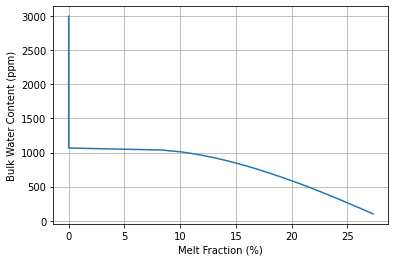

In [4]:
p_obj = pide.pide()

temperature = np.ones(100) * 1500
pressure = np.ones(100) * 3
bulk_water_array = np.linspace(100,3000,100)

p_obj.set_temperature(temperature)
p_obj.set_pressure(pressure)

#setting up a simple lherzolite composition
p_obj.set_composition_solid_mineral(ol = 0.6,opx = 0.3, cpx = 0.05, garnet = 0.05)
#setting the mineral conductivity choices
p_obj.set_mineral_conductivity_choice(ol = 4, opx = 0, garnet = 0, cpx = 6)
p_obj.set_solid_phs_mix_method(1) #HS lower bound

#Setting up Sifre2014 as the conductivity choice
p_obj.set_melt_fluid_conductivity_choice(melt = 0)

#Setting up melt CO2
p_obj.set_melt_properties(co2 = 100)

#Setting up bulk water.
#Try to avoid setting up melt_h2o from set_melt properties, because this will not distribute water among minerals.
p_obj.set_bulk_water(bulk_water_array)
p_obj.mantle_water_distribute()

#Setting up the melt-solid mixture relationship to Tubes model
p_obj.set_solid_melt_fluid_mix_method(1)
p_obj.set_mantle_water_partitions(opx_melt = 1,cpx_melt = 1)

cond_external = np.ones(len(temperature)) * (1.0/10.0)

#Now setting up the conductivity_solver_single_param
#we are using the parameter melt_fluid_mass_frac to estimate instead volumetric parameter melt_frac.
#This allows us to calculate the thermal expansion and water partitioning among melt and solid minerla mixture
#with more accuracy.
melt_frac_solution, residual_list = conductivity_solver_single_param(object = p_obj, cond_list = cond_external,
param_name = 'melt_fluid_mass_frac', upper_limit_list = np.ones(len(temperature)), lower_limit_list= np.zeros(len(temperature)),
search_start = 0.01, acceptence_threshold = 0.05, num_cpu = 1,simplify_fluid_density = False)




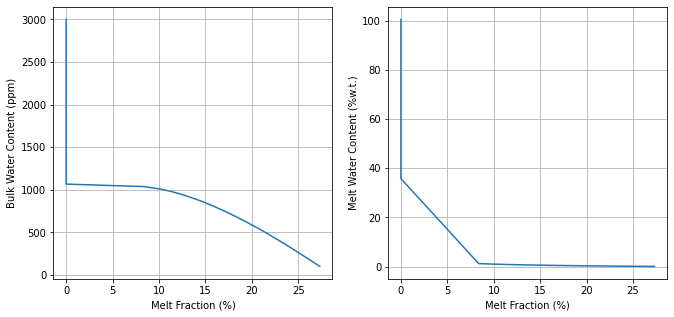

In [11]:
fig = plt.figure(figsize = (11,5))
ax = plt.subplot(121)
ax.plot(np.array(melt_frac_solution) * 1e2, bulk_water_array)
ax.set_xlabel('Melt Fraction (%)')
ax.set_ylabel('Bulk Water Content (ppm)')
ax.grid(which = 'both')

ax2 = plt.subplot(122)
ax2.plot(np.array(melt_frac_solution) * 1e2, p_obj.h2o_melt *1e-4)
ax2.set_xlabel('Melt Fraction (%)')
ax2.set_ylabel('Melt Water Content (%w.t.)')
ax2.grid(which = 'both')
plt.show()

Monte-Carlo loop is started
500000 total samples.
10000 burning samples.
Step size (std) for random walk are decreased to [190.0, 0.25] - Acceptance Rate: 0.18- Completed :% 2
Step size (std) for random walk are decreased to [190.0, 0.2375] - Acceptance Rate: 0.176- Completed :% 3
Step size (std) for random walk are decreased to [190.0, 0.225625] - Acceptance Rate: 0.178- Completed :% 3
Step size (std) for random walk are decreased to [190.0, 0.21434374999999997] - Acceptance Rate: 0.177- Completed :% 3
Step size (std) for random walk are decreased to [180.5, 0.21434374999999997] - Acceptance Rate: 0.175- Completed :% 3
Step size (std) for random walk are decreased to [171.475, 0.21434374999999997] - Acceptance Rate: 0.181- Completed :% 4
Step size (std) for random walk are decreased to [171.475, 0.20362656249999997] - Acceptance Rate: 0.182- Completed :% 4
Step size (std) for random walk are decreased to [162.90124999999998, 0.20362656249999997] - Acceptance Rate: 0.182- Completed :% 

Acceptence rate is good size: - Acceptance Rate: 0.232 - Completed :% 25
Acceptence rate is good size: - Acceptance Rate: 0.232 - Completed :% 25
Acceptence rate is good size: - Acceptance Rate: 0.232 - Completed :% 25
Acceptence rate is good size: - Acceptance Rate: 0.232 - Completed :% 26
Acceptence rate is good size: - Acceptance Rate: 0.232 - Completed :% 26
Acceptence rate is good size: - Acceptance Rate: 0.232 - Completed :% 26
Acceptence rate is good size: - Acceptance Rate: 0.232 - Completed :% 27
Acceptence rate is good size: - Acceptance Rate: 0.232 - Completed :% 27
Acceptence rate is good size: - Acceptance Rate: 0.232 - Completed :% 27
Acceptence rate is good size: - Acceptance Rate: 0.232 - Completed :% 27
Acceptence rate is good size: - Acceptance Rate: 0.232 - Completed :% 27
Acceptence rate is good size: - Acceptance Rate: 0.232 - Completed :% 28
Acceptence rate is good size: - Acceptance Rate: 0.232 - Completed :% 28
Acceptence rate is good size: - Acceptance Rate: 0.

Acceptence rate is good size: - Acceptance Rate: 0.236 - Completed :% 50
Acceptence rate is good size: - Acceptance Rate: 0.236 - Completed :% 50
Acceptence rate is good size: - Acceptance Rate: 0.236 - Completed :% 51
Acceptence rate is good size: - Acceptance Rate: 0.236 - Completed :% 51
Acceptence rate is good size: - Acceptance Rate: 0.236 - Completed :% 51
Acceptence rate is good size: - Acceptance Rate: 0.236 - Completed :% 52
Acceptence rate is good size: - Acceptance Rate: 0.236 - Completed :% 52
Acceptence rate is good size: - Acceptance Rate: 0.236 - Completed :% 52
Acceptence rate is good size: - Acceptance Rate: 0.236 - Completed :% 52
Acceptence rate is good size: - Acceptance Rate: 0.236 - Completed :% 52
Acceptence rate is good size: - Acceptance Rate: 0.236 - Completed :% 53
Acceptence rate is good size: - Acceptance Rate: 0.236 - Completed :% 53
Acceptence rate is good size: - Acceptance Rate: 0.236 - Completed :% 53
Acceptence rate is good size: - Acceptance Rate: 0.

Acceptence rate is good size: - Acceptance Rate: 0.237 - Completed :% 75
Acceptence rate is good size: - Acceptance Rate: 0.237 - Completed :% 75
Acceptence rate is good size: - Acceptance Rate: 0.237 - Completed :% 75
Acceptence rate is good size: - Acceptance Rate: 0.237 - Completed :% 75
Acceptence rate is good size: - Acceptance Rate: 0.237 - Completed :% 75
Acceptence rate is good size: - Acceptance Rate: 0.237 - Completed :% 76
Acceptence rate is good size: - Acceptance Rate: 0.237 - Completed :% 76
Acceptence rate is good size: - Acceptance Rate: 0.237 - Completed :% 76
Acceptence rate is good size: - Acceptance Rate: 0.237 - Completed :% 77
Acceptence rate is good size: - Acceptance Rate: 0.237 - Completed :% 77
Acceptence rate is good size: - Acceptance Rate: 0.237 - Completed :% 77
Acceptence rate is good size: - Acceptance Rate: 0.237 - Completed :% 78
Acceptence rate is good size: - Acceptance Rate: 0.237 - Completed :% 78
Acceptence rate is good size: - Acceptance Rate: 0.

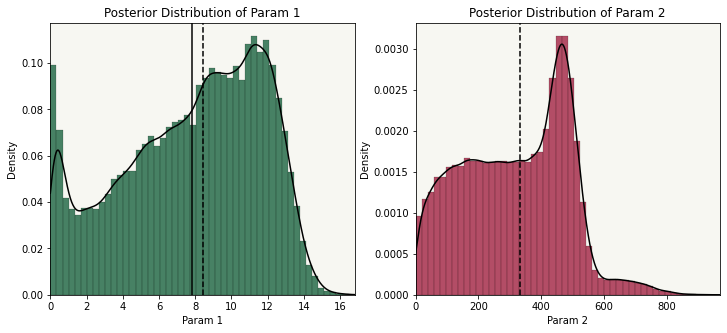

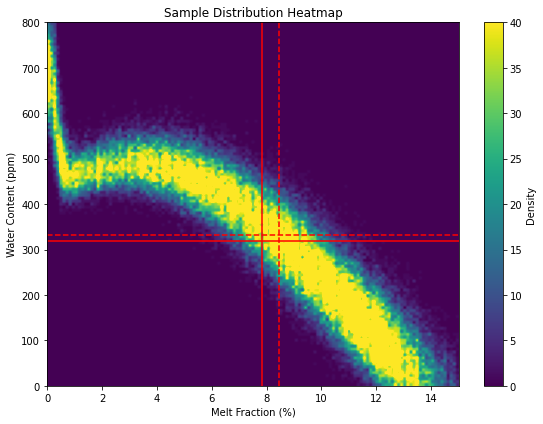

In [12]:
p_obj = pide.pide()

temperature = [1500]
pressure = [3]

p_obj.set_temperature(temperature)
p_obj.set_pressure(pressure)

#setting up a simple lherzolite composition
p_obj.set_composition_solid_mineral(ol = 0.6,opx = 0.3, cpx = 0.05, garnet = 0.05)
#setting the mineral conductivity choices
p_obj.set_mineral_conductivity_choice(ol = 4, opx = 0, garnet = 0, cpx = 6)
p_obj.set_solid_phs_mix_method(1) #HS lower bound

#Setting up Sifre2014 as the conductivity choice
p_obj.set_melt_fluid_conductivity_choice(melt = 0)

#Setting up melt CO2
p_obj.set_melt_properties(co2 = 100)

#Setting up the melt-solid mixture relationship to Tubes model
p_obj.set_solid_melt_fluid_mix_method(1)

p_obj.set_mantle_water_partitions(opx_melt = 1,cpx_melt = 1)

res_external = 10

#Bounds for the search space.
water_min = np.zeros(len(temperature))
water_max = 3000.0 * np.ones(len(temperature))
melt_min = 0.00 * np.ones(len(temperature))
melt_max = 0.5 * np.ones(len(temperature))

cond_external = [1.0/res_external]
initial_water = 1000
initial_melt = 0.3
initial_params = [[initial_water, initial_melt]]

sigma = 0.025 * np.ones(len(temperature))#in log
n_iterations = 500000
proposal_std = [200,0.25]
burning = 10000

samples, acceptance_rates, misfits, samples_all, misfits_all = conductivity_metropolis_hastings_two_param(object = p_obj, cond_list = cond_external,
initial_params = initial_params,param_name_1 = 'bulk_water',
param_name_2= "melt_fluid_mass_frac", upper_limits = (water_max,melt_max),
	lower_limits = (water_min,melt_min), sigma_cond = sigma,proposal_stds=proposal_std
	,n_iter = n_iterations, burning = burning, transition_zone = False,num_cpu = 1,adaptive_alg = True,
	step_size_limits = [25000,0.5])

water_samples = samples[0][:, 0]
melt_samples = samples[0][:, 1]

water_samples_all = samples_all[0][:, 0]
melt_samples_all = samples_all[0][:, 1]

plot_posterior_distribution_two_params(data_param_1 = melt_samples*1e2,data_param_2 = water_samples,
                                    file_name = f"melt_frac_distr.png",save = False)


plot_posterior_distribution_heatmap_two_params(data_param_1 = melt_samples*1e2,
data_param_2 = water_samples, param_1_min = 0, param_1_max = np.amax(melt_samples_all)*1e2,
param_2_min = 0, param_2_max = np.amax(water_samples_all),
param1_name = 'Melt Fraction (%)',
param2_name = "Water Content (ppm)",
file_name = f"melt_frac_solution.png",save = False)